# Install Detectron2

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 KB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp39-cp39-linux_x86_64.whl size=44089 sha256=1eea734adb3c0f1757fa37b406fec70f060c122c1c8390c973eb4080c71456db
  Stored in directory: /root/.cache/pip/wheels/68/be/8f/b6c454cd264e0b349b47f8ee00755511f277618af9e5dae20d
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.6.8 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatible.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

# Prepare data

In [ ]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [ ]:
!pip install retry
!pip install rasterio
!git clone https://github.com/WinnieCP/dsr_tree_project.git
from dsr_tree_project.create_data import utils as ut


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 KB 11.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 67.8 MB/s eta 0:00:00
Cloning into 'dsr_tree_project'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 107 (delta 50), reused 80 (delta 30), pack-reused 0
Receiving objects: 100% (107/107), 66.69 KiB | 16.67 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [ ]:
# load Baumkataster
df = pd.read_csv('/gdrive/MyDrive/Berliner_Baeume/Baumkataster_-_Berlin.csv')

df = df.loc[:, ['X', 'Y', 'kronedurch', 'baumhoehe']]
df.kronedurch[df.kronedurch.isnull()] = 8
df.kronedurch[df.kronedurch  < 5] = 5

df = ut.add_new_crs_to_df(df, 'EPSG:25833')

df_val = pd.read_csv('/gdrive/MyDrive/Berliner_Baeume/Val_Baumkataster.csv') # manually labeled trees for validation set
df_train = pd.read_csv('/gdrive/MyDrive/Berliner_Baeume/Train_Baumkataster.csv') # manually labeled trees for difficult area in training set

<ipython-input-6-830a0ff18ac0>:2: DtypeWarning: Columns (5,11,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/gdrive/MyDrive/Berliner_Baeume/Baumkataster_-_Berlin.csv')


In [ ]:
import glob
#img_dir = "/gdrive/MyDrive/Berliner_Baeume/test_tiles"
img_dir_train = "/gdrive/MyDrive/Berliner_Baeume/training_dataset/Wilmersdorf_1024x640/RGB"
#img_dir_train = "/gdrive/MyDrive/Berliner_Baeume/test_tiles_800x1024"
img_dir_val = "/gdrive/MyDrive/Berliner_Baeume/validation_dataset/validation_1024x640/RGB"

list_tiles_train = [os.path.basename(x) for x in glob.glob(f"{img_dir_train}/*.tif")]
list_tiles_train = [
    (os.path.basename(f).split(".")[0])
    for f in list_tiles_train
]

list_tiles_train1 = []
list_tiles_train2 = []

for tile in list_tiles_train:
  if int(tile.split('_')[1]) < 50:
    list_tiles_train2.append(tile)
  else:
    list_tiles_train1.append(tile)

list_tiles_val = [os.path.basename(x) for x in glob.glob(f"{img_dir_val}/*.tif")]
list_tiles_val = [
    (os.path.basename(f).split(".")[0])
    for f in list_tiles_val
]

In [ ]:
import rasterio
import rasterio.plot
import rasterio.features
import rasterio.warp


def get_tree_dicts(d):
    if d == 'train1':
      img_dir = img_dir_train
      tiles_set = list_tiles_train1
      used_df = df
    if d == 'train2':
      img_dir = img_dir_train
      tiles_set = list_tiles_train2
      used_df = df_train
    else:
      img_dir = img_dir_val
      tiles_set = list_tiles_val
      used_df = df_val

    dataset_dicts = []
    for tile in tiles_set:
        record = {}

        filename = os.path.join(img_dir, tile + '.tif')
        tiff = rasterio.open(filename)

        record["file_name"] = filename
        record["image_id"] = filename
        record["height"] = tiff.height
        record["width"] = tiff.width

        objs = []
        x_min, y_min, x_max, y_max = ut.compute_bbox_xyxy(tiff, used_df)

        for i in range(x_min.size):
            obj = {
                "bbox": [x_min[i], y_min[i], x_max[i], y_max[i]],
                "bbox_mode": BoxMode.XYXY_ABS,
                #"segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train1", "train2", "val"]:
    DatasetCatalog.register("tree_" + d, lambda d=d: get_tree_dicts(d))
    MetadataCatalog.get("tree_" + d).set(thing_classes=["tree"])
tree_metadata = MetadataCatalog.get("tree_train1")

/usr/local/lib/python3.9/dist-packages/rasterio/transform.py:124: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/rasterio/transform.py:124: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/rasterio/transform.py:124: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/rasterio/transform.py:124: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/rasterio/transform.py:124: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/rasterio/transform.py

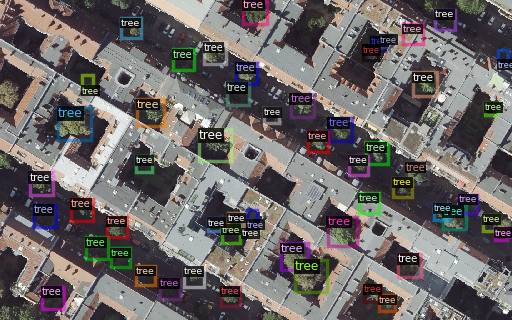

In [ ]:
dataset_dicts = get_tree_dicts("train1")
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=tree_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

# Train

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))   # I changed the model to detection
cfg.DATASETS.TRAIN = ("tree_train1",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1500    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/31 08:43:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.9/dist-packages/rasterio/transform.py:124: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


[03/31 08:43:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/31 08:43:21 d2.data.build]: Using training sampler TrainingSampler
[03/31 08:43:21 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/31 08:43:21 d2.data.common]: Serializing 24 elements to byte tensors and concatenating them all ...
[03/31 08:43:21 d2.data.common]: Serialized dataset takes 0.14 MiB
[03/31 08:43:21 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[03/31 08:43:21 d2.engine.train_loop]: Starting training from iteration 0
[03/31 08:43:32 d2.utils.events]:  eta: 0:12:15  iter: 19  total_loss: 3.113  loss_cls: 0.7489  loss_box_reg: 0.3397  loss_rpn_cls: 1.662  loss_rpn_loc: 0.3478    time: 0.4873  last_time: 0.4970  data_time: 0.0367  last_data_time: 0.0151   lr: 4.9953e-06  max_mem: 3261M
[03/31 08:43:42 d2.utils.events]:  eta: 0:12:08  iter: 39  total_loss: 2.238  loss_cls: 0.718  loss_box_reg: 0.3986  loss_rpn_cls: 0.8154  loss_rpn_loc: 0.3124    time: 0.4940  last_time: 0.4670  data_time: 0.0126  last_data_time: 0.0056   lr: 9.9902e-06  max_mem: 3261M
[03/31 08:43:52 d2.utils.events]:  eta: 0:12:01  iter: 59  total_loss: 1.911  loss_cls: 0.6632  loss_box_reg: 0.5341  loss_rpn_cls: 0.4413  loss_rpn_loc: 0.2578    time: 0.4997  last_time: 0.5703  data_time: 0.0111  last_data_time: 0.0241   lr: 1.4985e-05  max_mem: 3261M
[03/31 08:44:02 d2.utils.events]:  eta: 0:11:52  iter: 79  total_loss: 1.861  loss_cls: 0.6088  loss_box_reg: 0.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.SOLVER.BASE_LR = 0.0001
cfg.DATASETS.TRAIN = ("tree_train1",)
cfg.SOLVER.MAX_ITER = 2000
trainer2 = DefaultTrainer(cfg)
trainer2.resume_or_load(resume=True)
trainer2.train()

[03/31 09:06:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.9/dist-packages/rasterio/transform.py:124: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


[03/31 09:06:49 d2.engine.hooks]: Loading scheduler from state_dict ...
[03/31 09:06:49 d2.engine.train_loop]: Starting training from iteration 1500
[03/31 09:06:58 d2.utils.events]:  eta: 0:03:50  iter: 1519  total_loss: 0.9264  loss_cls: 0.2916  loss_box_reg: 0.4534  loss_rpn_cls: 0.03518  loss_rpn_loc: 0.1432    time: 0.4746  last_time: 0.4493  data_time: 0.0220  last_data_time: 0.0073   lr: 0.00025  max_mem: 3263M
[03/31 09:07:08 d2.utils.events]:  eta: 0:03:45  iter: 1539  total_loss: 0.9926  loss_cls: 0.3233  loss_box_reg: 0.4664  loss_rpn_cls: 0.03542  loss_rpn_loc: 0.1482    time: 0.4820  last_time: 0.5459  data_time: 0.0082  last_data_time: 0.0064   lr: 0.00025  max_mem: 3263M
[03/31 09:07:18 d2.utils.events]:  eta: 0:03:36  iter: 1559  total_loss: 0.9287  loss_cls: 0.2988  loss_box_reg: 0.4624  loss_rpn_cls: 0.03199  loss_rpn_loc: 0.1401    time: 0.4866  last_time: 0.5012  data_time: 0.0122  last_data_time: 0.0061   lr: 0.00025  max_mem: 3263M
[03/31 09:07:28 d2.utils.events]

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.OUTPUT_DIR = "/gdrive/MyDrive/Berliner_Baeume/Notebooks/Models/Detectron2"
cfg.SOLVER.BASE_LR = 0.00005
cfg.DATASETS.TRAIN = ("tree_train1",)
cfg.SOLVER.MAX_ITER = 500

trainer3 = DefaultTrainer(cfg)
trainer3.resume_or_load(resume=True)
trainer3.train()

[03/31 09:21:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

# Validate

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set a custom testing threshold
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.2 #threshold for overlap
predictor = DefaultPredictor(cfg)

[03/31 09:26:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /gdrive/MyDrive/Berliner_Baeume/Notebooks/Models/Detectron2/model_final.pth ...


/usr/local/lib/python3.9/dist-packages/rasterio/transform.py:124: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


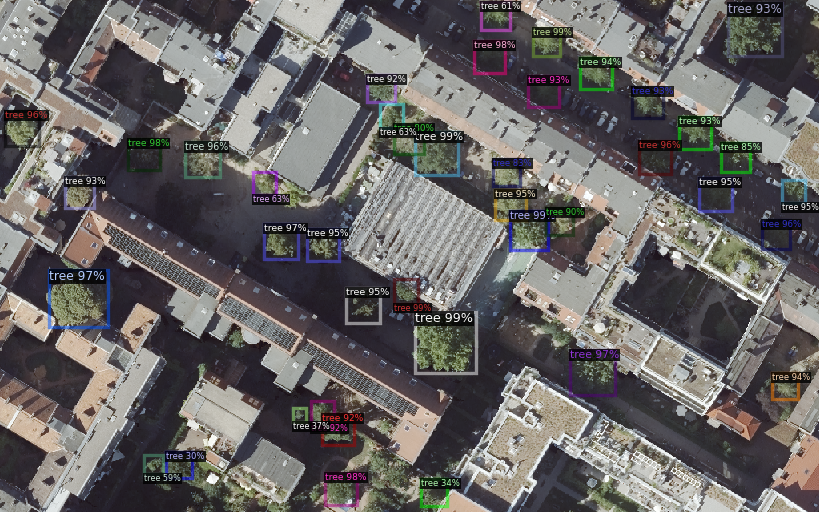

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_tree_dicts("val")
for d in random.sample(dataset_dicts, 1):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=tree_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE     # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

# Evaluate

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("tree_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "tree_val")
APs = inference_on_dataset(predictor.model, val_loader, evaluator)['bbox']

[03/31 09:26:22 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[03/31 09:26:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/31 09:26:22 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/31 09:26:22 d2.data.common]: Serializing 24 elements to byte tensors and concatenating them all ...
[03/31 09:26:22 d2.data.common]: Serialized dataset takes 0.14 MiB
[03/31 09:26:22 d2.evaluation.evaluator]: Start inference on 24 batches


/usr/local/lib/python3.9/dist-packages/rasterio/transform.py:124: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


[03/31 09:26:24 d2.evaluation.evaluator]: Inference done 11/24. Dataloading: 0.0047 s/iter. Inference: 0.1279 s/iter. Eval: 0.0012 s/iter. Total: 0.1339 s/iter. ETA=0:00:01
[03/31 09:26:26 d2.evaluation.evaluator]: Total inference time: 0:00:02.444640 (0.128665 s / iter per device, on 1 devices)
[03/31 09:26:26 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.119899 s / iter per device, on 1 devices)
[03/31 09:26:26 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/31 09:26:26 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[03/31 09:26:26 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.96s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0

In [ ]:
APs

{'AP': 48.03245708038566,
 'AP50': 86.8622407543464,
 'AP75': 49.70823091377636,
 'APs': 31.515647053329243,
 'APm': 53.89466214479799,
 'APl': 75.0}

# Load model

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))   # I changed the model to detection
cfg.DATASETS.TRAIN = ("tree_train1",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1500    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join("/gdrive/MyDrive/Berliner_Baeume/Notebooks/Models/Detectron2", "model_final_AP_48_AP50_87_AP75_50.pth")

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set a custom testing threshold
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.2 #threshold for overlap
predictor = DefaultPredictor(cfg)

[03/31 11:24:45 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /gdrive/MyDrive/Berliner_Baeume/Notebooks/Models/Detectron2/model_final_AP_48_AP50_87_AP75_50.pth ...


/usr/local/lib/python3.9/dist-packages/rasterio/transform.py:124: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


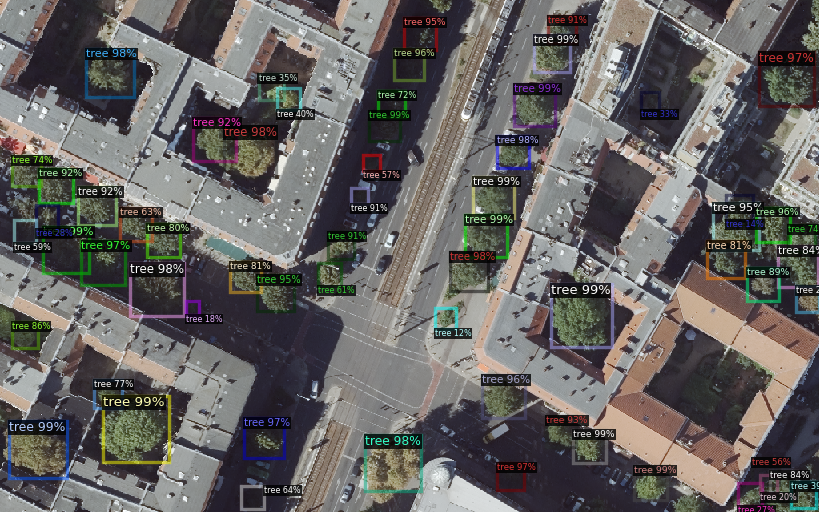

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_tree_dicts("val")
for d in random.sample(dataset_dicts, 1):
    im = cv2.imread(d["file_name"])
    #im = cv2.imread('/gdrive/MyDrive/Berliner_Baeume/validation_dataset/validation_1024/RGB/tile_09.tif')
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=tree_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE     # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("tree_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "tree_val")
APs = inference_on_dataset(predictor.model, val_loader, evaluator)['bbox']
APs

[03/31 11:24:49 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[03/31 11:24:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]


/usr/local/lib/python3.9/dist-packages/rasterio/transform.py:124: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


[03/31 11:24:50 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/31 11:24:50 d2.data.common]: Serializing 24 elements to byte tensors and concatenating them all ...
[03/31 11:24:50 d2.data.common]: Serialized dataset takes 0.14 MiB
[03/31 11:24:50 d2.evaluation.evaluator]: Start inference on 24 batches
[03/31 11:24:51 d2.evaluation.evaluator]: Inference done 11/24. Dataloading: 0.0019 s/iter. Inference: 0.1191 s/iter. Eval: 0.0004 s/iter. Total: 0.1214 s/iter. ETA=0:00:01
[03/31 11:24:53 d2.evaluation.evaluator]: Total inference time: 0:00:02.332829 (0.122780 s / iter per device, on 1 devices)
[03/31 11:24:54 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.117523 s / iter per device, on 1 devices)
[03/31 11:24:54 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/31 11:24:54 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[03/31 11:24:54 d2.eval

{'AP': 48.57403756124261,
 'AP50': 88.47963653647781,
 'AP75': 49.70823091377636,
 'APs': 32.745504740012066,
 'APm': 54.047860015248325,
 'APl': 75.0}

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # set a custom testing threshold
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.2 #threshold for overlap
predictor = DefaultPredictor(cfg)

[03/31 11:14:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /gdrive/MyDrive/Berliner_Baeume/Notebooks/Models/Detectron2/model_final_AP_48_AP50_87_AP75_50.pth ...


/usr/local/lib/python3.9/dist-packages/rasterio/transform.py:124: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


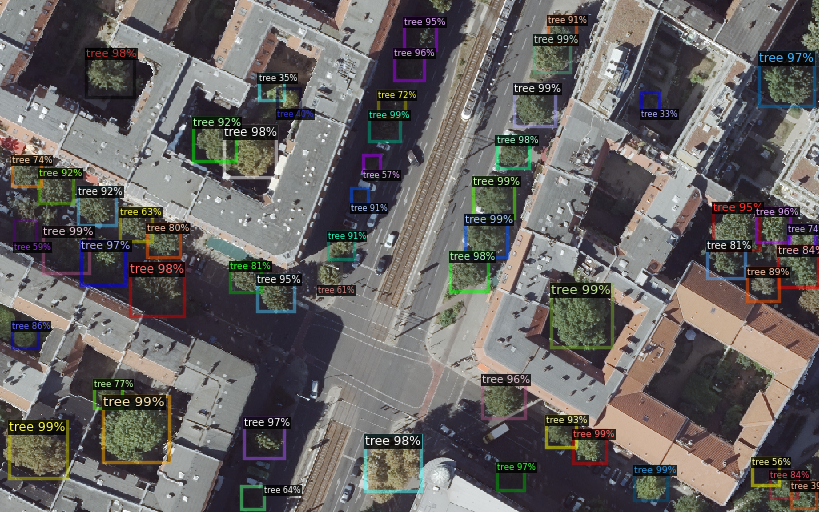

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_tree_dicts("val")
for d in random.sample(dataset_dicts, 1):
    im = cv2.imread(d["file_name"])
    #im = cv2.imread('/gdrive/MyDrive/Berliner_Baeume/validation_dataset/validation_1024/RGB/tile_09.tif')
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=tree_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE     # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("tree_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "tree_val")
APs = inference_on_dataset(predictor.model, val_loader, evaluator)['bbox']
APs

[03/31 11:15:20 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[03/31 11:15:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/31 11:15:20 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/31 11:15:20 d2.data.common]: Serializing 24 elements to byte tensors and concatenating them all ...
[03/31 11:15:20 d2.data.common]: Serialized dataset takes 0.14 MiB
[03/31 11:15:20 d2.evaluation.evaluator]: Start inference on 24 batches


/usr/local/lib/python3.9/dist-packages/rasterio/transform.py:124: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


[03/31 11:15:22 d2.evaluation.evaluator]: Inference done 11/24. Dataloading: 0.0018 s/iter. Inference: 0.1178 s/iter. Eval: 0.0005 s/iter. Total: 0.1201 s/iter. ETA=0:00:01
[03/31 11:15:23 d2.evaluation.evaluator]: Total inference time: 0:00:02.372601 (0.124874 s / iter per device, on 1 devices)
[03/31 11:15:24 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.116732 s / iter per device, on 1 devices)
[03/31 11:15:24 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/31 11:15:24 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[03/31 11:15:24 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.26s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0

{'AP': 48.03245708038566,
 'AP50': 86.8622407543464,
 'AP75': 49.70823091377636,
 'APs': 31.515647053329243,
 'APm': 53.89466214479799,
 'APl': 75.0}

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set a custom testing threshold
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.2 #threshold for overlap
predictor = DefaultPredictor(cfg)

[03/31 11:25:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /gdrive/MyDrive/Berliner_Baeume/Notebooks/Models/Detectron2/model_final_AP_48_AP50_87_AP75_50.pth ...


/usr/local/lib/python3.9/dist-packages/rasterio/transform.py:124: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


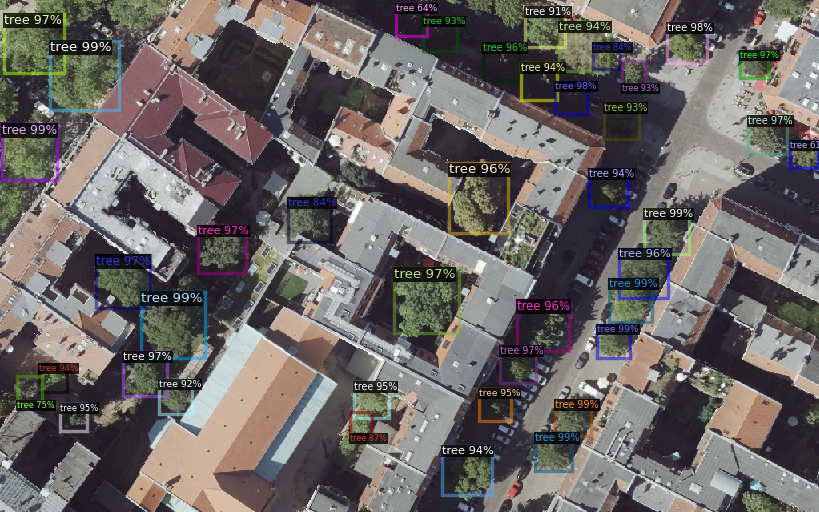

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_tree_dicts("val")
for d in random.sample(dataset_dicts, 1):
    im = cv2.imread(d["file_name"])
    #im = cv2.imread('/gdrive/MyDrive/Berliner_Baeume/validation_dataset/validation_1024/RGB/tile_09.tif')
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=tree_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE     # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("tree_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "tree_val")
APs = inference_on_dataset(predictor.model, val_loader, evaluator)['bbox']
APs

[03/31 11:25:14 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[03/31 11:25:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]


/usr/local/lib/python3.9/dist-packages/rasterio/transform.py:124: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


[03/31 11:25:15 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/31 11:25:15 d2.data.common]: Serializing 24 elements to byte tensors and concatenating them all ...
[03/31 11:25:15 d2.data.common]: Serialized dataset takes 0.14 MiB
[03/31 11:25:15 d2.evaluation.evaluator]: Start inference on 24 batches
[03/31 11:25:16 d2.evaluation.evaluator]: Inference done 11/24. Dataloading: 0.0020 s/iter. Inference: 0.1172 s/iter. Eval: 0.0003 s/iter. Total: 0.1195 s/iter. ETA=0:00:01
[03/31 11:25:19 d2.evaluation.evaluator]: Total inference time: 0:00:02.999602 (0.157874 s / iter per device, on 1 devices)
[03/31 11:25:19 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.116620 s / iter per device, on 1 devices)
[03/31 11:25:19 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/31 11:25:19 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[03/31 11:25:19 d2.eval

{'AP': 46.57173954763821,
 'AP50': 83.28913183366194,
 'AP75': 48.49925388067109,
 'APs': 29.026882892860357,
 'APm': 53.02586168969752,
 'APl': 75.0}